In [1]:
import os
from pathlib import Path

import requests
import tarfile
import py7zr
import pandas as pd
import geopandas as gpd
import shapely
import shapely.geometry
import shapely.ops
from shapely import affinity
import matplotlib.pylab as plt


DATA_DIR = Path('./data').expanduser()
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Plotting style defaults:
plot_styles = {
    'edgecolor': 'black',  # Sets the color of the border of each geometry in the plot to black
    'column': 'name',      # Specifies the column to be used for coloring the geometries based on its values
    'legend': False,       # Disables the legend for the plot
    'cmap': 'tab20',       # Sets the colormap to 'tab20' which provides a distinct set of colors for visual differentiation
    'linewidth': 0.25       # Sets the thickness of the edges/borders of the geometries
}


def download_file(url, local_filename):
    with requests.get(url, stream=True) as response:
        response.raise_for_status()  # Vérifie que la requête a réussi
        with open(local_filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:  # Filtre les morceaux vides
                    file.write(chunk)

def unzip_file(zipped_path, extract_path):

    # Extract the archive
    with py7zr.SevenZipFile(zipped_path, mode='r') as archive:
        archive.extractall(path=extract_path)

def convert_shp_to_geojson(shapefile_path, geojson_path):
    # Load shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Save as GeoJSON
    gdf.to_file(geojson_path, driver="GeoJSON")


def reposition(df, idx, xoff=None, yoff=None, xscale=None, yscale=None, simplify=None):

    origin = df[idx].union_all().centroid
    
    def scale_and_move(geom):
        if xscale or yscale:
            geom = affinity.scale(geom, xfact=xscale or 1, yfact=yscale or 1, origin=origin)
        if xoff or yoff:
            geom = affinity.translate(geom, xoff or 0, yoff or 0)
        if simplify:
            geom = geom.simplify(simplify, preserve_topology=False)
        return geom

    df = df.copy()
    df.loc[idx, 'geometry'] = df.loc[idx, 'geometry'].apply(scale_and_move)
    return df

In [2]:
# https://geoservices.ign.fr/adminexpress

url = "https://data.geopf.fr/telechargement/download/ADMIN-EXPRESS/ADMIN-EXPRESS_3-2__SHP_WGS84G_FRA_2025-02-17/ADMIN-EXPRESS_3-2__SHP_WGS84G_FRA_2025-02-17.7z"
local_filename = DATA_DIR / "ADMIN-EXPRESS_3-2__SHP_WGS84G_FRA_2025-02-17.7z"

zipped_path = DATA_DIR / "ADMIN-EXPRESS_3-2__SHP_WGS84G_FRA_2025-02-17.7z"  # or "your_archive.tar.gz"

# Peut prendre du temps
download_file(url, local_filename)
print("Téléchargement terminé", local_filename)
# Peut prendre du temps
unzip_file(zipped_path, DATA_DIR)
print("Extraction terminée")

admin_express_dir = DATA_DIR / "ADMIN-EXPRESS_3-2__SHP_WGS84G_FRA_2025-02-17/ADMIN-EXPRESS/1_DONNEES_LIVRAISON_2025-02-00188/ADE_3-2_SHP_WGS84G_FRA-ED2025-02-17"
admin_express_geojson_path = DATA_DIR / "COMMUNE.geojson"
# Peut prendre du temps
convert_shp_to_geojson(admin_express_dir / "COMMUNE.shp", admin_express_geojson_path)
print("Fichier COMMUNE.shp converti en COMMUNE.geojson")

Téléchargement terminé data/ADMIN-EXPRESS_3-2__SHP_WGS84G_FRA_2025-02-17.7z
Extraction terminée
Fichier COMMUNE.shp converti en COMMUNE.geojson


In [3]:
# INSEE COG https://www.insee.fr/fr/information/8377162

download_file("https://www.insee.fr/fr/statistiques/fichier/8377162/v_commune_2025.csv", DATA_DIR / "v_commune_2025.csv")
download_file("https://www.insee.fr/fr/statistiques/fichier/8377162/v_departement_2025.csv", DATA_DIR / "v_departement_2025.csv")
download_file("https://www.insee.fr/fr/statistiques/fichier/8377162/v_region_2025.csv", DATA_DIR / "v_region_2025.csv")

# Fichier v_commune_2025.csv du COG 2025
cog_communes = pd.read_csv(DATA_DIR / 'v_commune_2025.csv')
#cog_communes = cog_communes[['COM', 'DEP']]
# Fichier v_departement_2025.csv du COG 2025
cog_departements = pd.read_csv(DATA_DIR / 'v_departement_2025.csv')
cog_departements = cog_departements[['DEP', 'LIBELLE']]
# Fichier v_region_2025.csv du COG 2025
cog_regions = pd.read_csv(DATA_DIR / 'v_region_2025.csv')
cog_regions = cog_regions[['REG', 'LIBELLE']]

In [4]:
# https://www.data.gouv.fr/fr/datasets/competence-territoriale-gendarmerie-et-police-nationales/#/resources

download_file("https://www.data.gouv.fr/fr/datasets/r/c53cd4d4-4623-4772-9b8c-bc72a9cdf4c2", DATA_DIR / "competences_pn_gn.csv")

competences_pn_gn = pd.read_csv(DATA_DIR / "competences_pn_gn.csv", sep=";")

communes_cpn = competences_pn_gn[competences_pn_gn['institution']=='PN']

communes_cpn.to_csv(DATA_DIR / 'communes_cpn.csv', index=False)

ADMIN EXPRESS chargé
Fusion avec COG communes terminé
Fusion avec COG départements terminé
Repositionnement des outre-mer terminé
Fusion avec COG régions terminé
Communes sans départements d'après l'INSEE COG communes
Empty GeoDataFrame
Columns: [ID, name_commune, NOM_M, INSEE_COM, STATUT, POPULATION, INSEE_CAN, INSEE_ARR, INSEE_DEP, INSEE_REG, SIREN_EPCI, geometry, TYPECOM, COM, REG, DEP, CTCD, ARR, TNCC, NCC, NCCENR, LIBELLE_x, CAN, COMPARENT, name_dep, name_reg, name_dz]
Index: []

[0 rows x 27 columns]


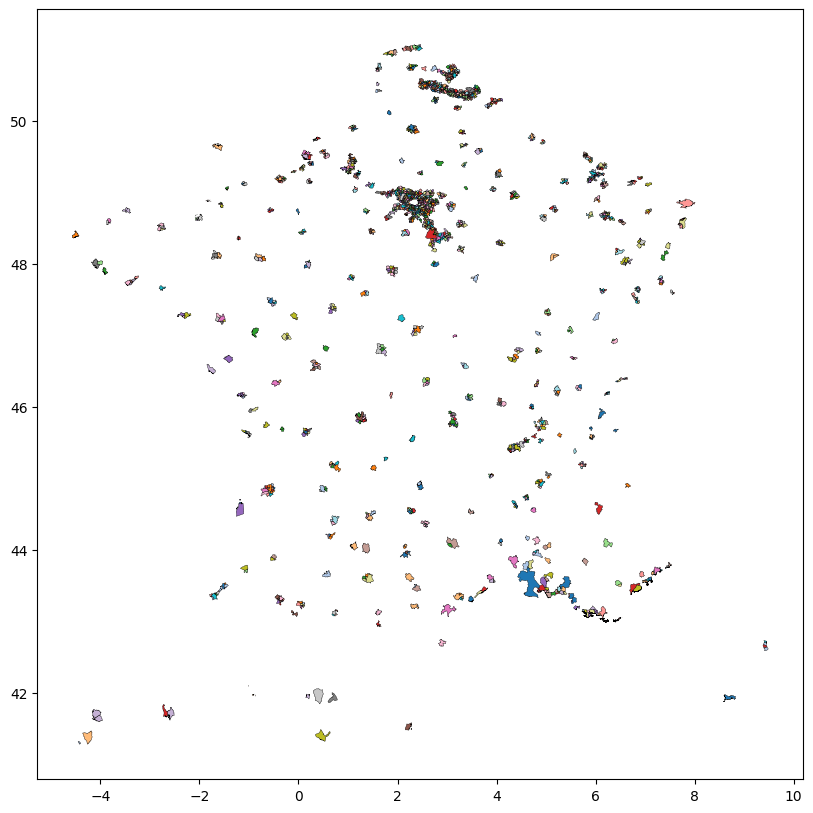

In [5]:
communes_admin_express = gpd.read_file(DATA_DIR / 'COMMUNE.geojson')
print("ADMIN EXPRESS chargé")

cpn = pd.read_csv(DATA_DIR / 'communes_cpn.csv')

# Renommer la colonne 'NOM' => 'name_commune'
communes_admin_express = communes_admin_express.rename(columns={"NOM": "name_commune"})

# Fusionner les CPN avec le COG Communes
communes_admin_express = pd.merge(communes_admin_express, cog_communes, left_on='INSEE_COM', right_on='COM')
print("Fusion avec COG communes terminé")
# Fusion avec le COG Départements
communes_admin_express = pd.merge(communes_admin_express, cog_departements, on='DEP')
communes_admin_express = communes_admin_express.rename(columns={'LIBELLE_y': 'name_dep'})
print("Fusion avec COG départements terminé")

# Repositionner les outre-mer proches de la métropole
communes_admin_express = reposition(communes_admin_express, communes_admin_express.name_dep=='Guadeloupe', 57.4, 25.4, 1.5, 1.5)
communes_admin_express = reposition(communes_admin_express, communes_admin_express.name_dep=='Martinique', 58.4, 27.1, 1.5, 1.5)
communes_admin_express = reposition(communes_admin_express, communes_admin_express.name_dep=='Guyane', 52, 37.7, 0.35, 0.35)
communes_admin_express = reposition(communes_admin_express, communes_admin_express.name_dep=='La Réunion', -55, 62.8, 1.5, 1.5)
communes_admin_express = reposition(communes_admin_express, communes_admin_express.name_dep=='Mayotte', -43, 54.3, 1.5, 1.5)
print("Repositionnement des outre-mer terminé")

# Fusion avec le COG Régions
communes_admin_express = pd.merge(communes_admin_express, cog_regions, on='REG')
communes_admin_express = communes_admin_express.rename(columns={'LIBELLE': 'name_reg'})
print("Fusion avec COG régions terminé")

# Ajouter une colonne Zone de défense
map_region_to_dz = {
    'Auvergne-Rhône-Alpes': 'Sud-Est',
    'Bourgogne-Franche-Comté': 'Est',
    'Bretagne': 'Ouest',
    'Centre-Val de Loire': 'Ouest',
    'Corse': 'Sud',
    'Grand Est': 'Est',
    'Guadeloupe': 'Antilles',
    'Guyane':  'Guyane',
    'Hauts-de-France': 'Nord',
    'La Réunion': 'Sud de l\'Océan Indien',
    'Martinique': 'Antilles',
    'Mayotte': "Sud de l'Océan Indien",
    'Normandie': 'Ouest',
    'Nouvelle-Aquitaine': 'Sud-Ouest',
    'Occitanie': 'Sud',
    'Pays de la Loire': 'Ouest',
    'Provence-Alpes-Côte d\'Azur': 'Sud',
    'Île-de-France': 'Paris',
}
communes_admin_express['name_dz'] = communes_admin_express['name_reg'].apply(lambda region: map_region_to_dz[region])

# Garder les communes qui appartiennent à une CPN
cpn_admin_express = communes_admin_express[communes_admin_express['INSEE_COM'].isin(cpn['code_commune'])]

print("Communes sans départements d'après l'INSEE COG communes")
print(cpn_admin_express[cpn_admin_express['DEP'].isna()])

cpn_admin_express.to_file(DATA_DIR / "cpn.geojson", driver="GeoJSON")

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

cpn_admin_express.rename(columns={"name_commune": "name"}).plot(ax=ax, figsize=(25, 12), **plot_styles)

# Save as SVG and PNG
plt.savefig(DATA_DIR / "france_cpn.svg", bbox_inches="tight", dpi=300)
plt.savefig(DATA_DIR / "france_cpn.png", bbox_inches="tight", dpi=300)

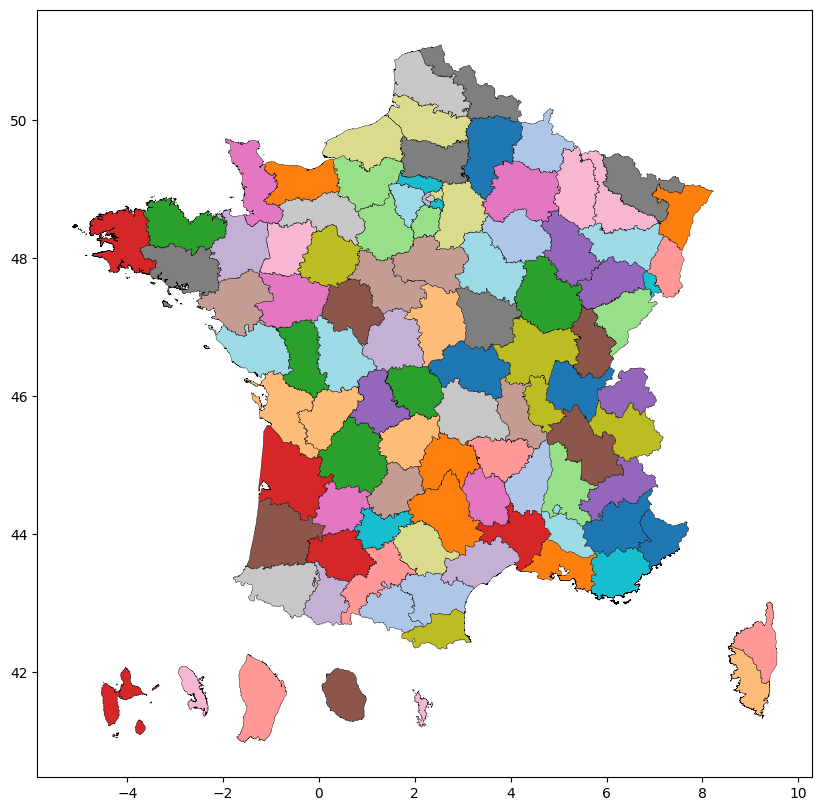

In [6]:
departements_admin_express = communes_admin_express.dissolve(by="name_dep").reset_index()
departements_admin_express.to_file(DATA_DIR / "departements.geojson", driver="GeoJSON")

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

departements_admin_express.rename(columns={"name_dep": "name"}).plot(ax=ax, figsize=(10, 7), **plot_styles)

# Save as SVG and PNG
plt.savefig(DATA_DIR / "france_departements.svg", bbox_inches="tight", dpi=300)
plt.savefig(DATA_DIR / "france_departements.png", bbox_inches="tight", dpi=300)

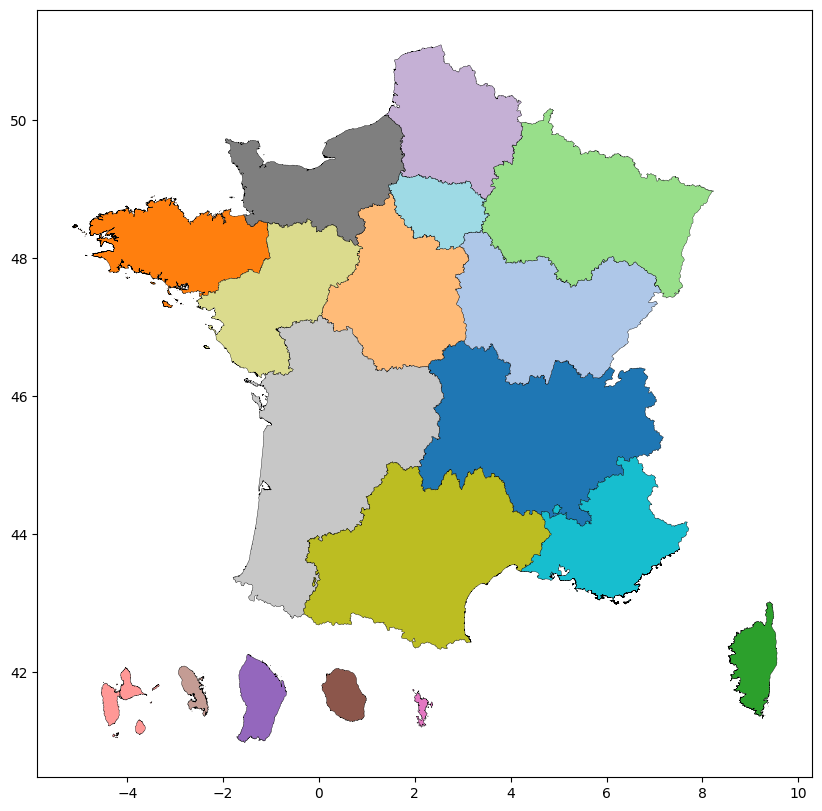

In [7]:
regions_admin_express = departements_admin_express.dissolve(by="name_reg").reset_index()
regions_admin_express.to_file(DATA_DIR / "regions.geojson", driver="GeoJSON")

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

regions_admin_express.rename(columns={"name_reg": "name"}).plot(ax=ax, figsize=(10, 7), **plot_styles)

# Save as SVG and PNG
plt.savefig(DATA_DIR / "france_regions.svg", bbox_inches="tight", dpi=300)
plt.savefig(DATA_DIR / "france_regions.png", bbox_inches="tight", dpi=300)

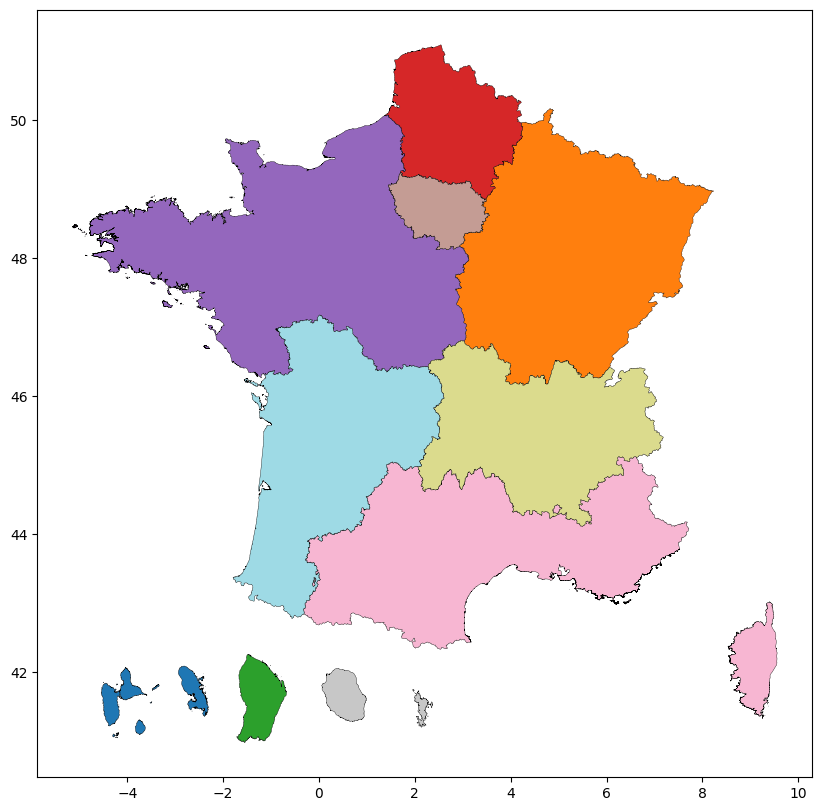

In [8]:
dz_admin_express = regions_admin_express.dissolve(by=['name_dz']).reset_index()
dz_admin_express.to_file(DATA_DIR / "dz.geojson", driver="GeoJSON")

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
#france_dz[france_dz['name']==dz].plot(ax=ax)

dz_admin_express.rename(columns={"name_dz": "name"}).plot(ax=ax, figsize=(10, 7), **plot_styles)

# Save as SVG and PNG
plt.savefig(DATA_DIR / "france_dz.svg", bbox_inches="tight", dpi=300)
plt.savefig(DATA_DIR / "france_dz.png", bbox_inches="tight", dpi=300)

In [ ]:
for name_dz in communes_admin_express['name_dz'].unique():
    dz_data = communes_admin_express[communes_admin_express['name_dz']==name_dz]
    output_path = DATA_DIR / f"dz_{name_dz}.geojson"
    dz_data.to_file(output_path, driver="GeoJSON")

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))
    dz_data.plot(ax=ax, color="lightblue", edgecolor="black")  # Plot geometries
    
    # Customize plot (optional)
    ax.set_title(f"Zone de défense {name_dz}", fontsize=15)
    ax.set_axis_off()  # Remove axes
    
    # Save as SVG or PNG
    output_path_svg = DATA_DIR / f"dz_{name_dz}.svg"
    output_path_png = DATA_DIR / f"dz_{name_dz}.png"
    plt.savefig(output_path_svg, bbox_inches="tight", dpi=300)
    plt.savefig(output_path_png, bbox_inches="tight", dpi=300)
    plt.close()  # Close the plot to free memory
    print(f"Zone de défense {name_dz} sauvegardée")
    
for code_reg in communes_admin_express['INSEE_REG'].unique():
    reg_data = communes_admin_express[communes_admin_express['INSEE_REG']==code_reg]
    output_path = DATA_DIR / f"region_{code_reg}.geojson"
    reg_data.to_file(output_path, driver="GeoJSON")

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))
    reg_data.plot(ax=ax, color="lightblue", edgecolor="black")  # Plot geometries
    
    # Customize plot (optional)
    ax.set_title(f"Région {code_reg}", fontsize=15)
    ax.set_axis_off()  # Remove axes
    
    # Save as SVG or PNG
    output_path_svg = DATA_DIR / f"region_{code_reg}.svg"
    output_path_png = DATA_DIR / f"region_{code_reg}.png"
    plt.savefig(output_path_svg, bbox_inches="tight", dpi=300)
    plt.savefig(output_path_png, bbox_inches="tight", dpi=300)
    plt.close()  # Close the plot to free memory
    print(f"Région {code_reg} sauvegardée")


for code_dep in communes_admin_express['INSEE_DEP'].unique():
    dep_data = communes_admin_express[communes_admin_express['INSEE_DEP']==code_dep]
    output_path = DATA_DIR / f"departement_{code_dep}.geojson"
    dep_data.to_file(output_path, driver="GeoJSON")

     # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))
    dep_data.plot(ax=ax, color="lightblue", edgecolor="black")  # Plot geometries
    
    # Customize plot (optional)
    ax.set_title(f"Départment {code_dep}", fontsize=15)
    ax.set_axis_off()  # Remove axes
    
    # Save as SVG or PNG
    output_path_svg = DATA_DIR / f"departement_{code_dep}.svg"
    output_path_png = DATA_DIR / f"departement_{code_dep}.png"
    plt.savefig(output_path_svg, bbox_inches="tight", dpi=300)
    plt.savefig(output_path_png, bbox_inches="tight", dpi=300)
    plt.close()  # Close the plot to free memory
    print(f"Département {code_dep} sauvegardée")

Zone de défense Sud sauvegardée
Zone de défense Ouest sauvegardée
Zone de défense Est sauvegardée


In [ ]:
communes_admin_express[['INSEE_DEP', 'name_dep']].drop_duplicates().sort_values('INSEE_DEP').to_csv(DATA_DIR / 'insee_dep_name_dep.csv', index=False)
communes_admin_express[['INSEE_REG', 'name_reg']].drop_duplicates().sort_values('INSEE_REG').to_csv(DATA_DIR / 'insee_reg_name_reg.csv', index=False)